In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

In [2]:
tickers = {
    "SPC": "^GSPC",  # Cap-weighted index
    "SPE": "RSP"     # Equal-weight ETF
}

start_date = "2005-01-01"
end_date = "2025-05-31"

# Get adjusted monthly close
df = yf.download(list(tickers.values()), start=start_date, end=end_date, auto_adjust=True, interval="1mo")
close_df = df["Close"].copy()
close_df.columns = tickers.keys()
close_df.dropna(inplace=True)

returns_df = close_df.pct_change().dropna()
returns_df["Innovation Portfolio"] = returns_df["SPC"] - returns_df["SPE"]
returns_df = returns_df.iloc[:-1]

print(returns_df.head(10))

[*********************100%***********************]  2 of 2 completed

                 SPC       SPE  Innovation Portfolio
Date                                                
2005-02-01  0.021275  0.018903              0.002372
2005-03-01 -0.015915 -0.019118              0.003202
2005-04-01 -0.029712 -0.020109             -0.009603
2005-05-01  0.044957  0.029952              0.015005
2005-06-01  0.012934 -0.000143              0.013076
2005-07-01  0.053598  0.035968              0.017630
2005-08-01 -0.008729 -0.011222              0.002493
2005-09-01  0.002340  0.006949             -0.004609
2005-10-01 -0.024217 -0.017741             -0.006477
2005-11-01  0.045515  0.035186              0.010329


In [4]:
cov_matrix = returns_df[["SPE", "Innovation Portfolio"]].cov()

In [5]:
cov_matrix

,SPE,Innovation Portfolio
SPE,0.001870,0.000211
Innovation Portfolio,0.000211,0.000226


In [15]:
cov_np = cov_matrix.values

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(cov_np)  # use eigh for symmetric matrices

# Sort eigenvalues and eigenvectors in descending order
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Create a DataFrame for clarity
pca_components = pd.DataFrame(
    eigenvectors,
    index=cov_matrix.columns,
    columns=[f'PC{i+1}' for i in range(len(eigenvectors))]
)

In [12]:
pc1 = eigenvalues[0] / sum(eigenvalues)
pc2 = eigenvalues[1] / sum(eigenvalues)

In [13]:
pc1

0.9050449543521453

In [14]:
pc2

0.09495504564785467

In [17]:
print(pca_components)

                           PC1       PC2
SPE                  -0.992145  0.125096
Innovation Portfolio -0.125096 -0.992145


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

window = 36  # rolling window size (e.g. 36 days or months)
assets = ["SPE", "Innovation Portfolio"]

# Initialize result storage
dates = []
explained_var_pc1 = []
explained_var_pc2 = []
pc1_spe_loading = []
pc1_innovation_loading = []

for i in range(window, len(returns_df)):
    window_returns = returns_df[assets].iloc[i - window:i].dropna()

    # Ensure we have full data
    if window_returns.shape[0] < window:
        continue

    # Covariance matrix
    cov = window_returns.cov()
    cov_np = cov.values

    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov_np)
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Track results
    dates.append(returns_df.index[i])
    explained_var_pc1.append(eigvals[0] / eigvals.sum())
    explained_var_pc2.append(eigvals[1] / eigvals.sum())
    pc1_spe_loading.append(eigvecs[0, 0])
    pc1_innovation_loading.append(eigvecs[1, 0])


In [19]:
rolling_pca_df = pd.DataFrame({
    "PC1 Explained Var": explained_var_pc1,
    "PC2 Explained Var": explained_var_pc2,
    "PC1 SPE Loading": pc1_spe_loading,
    "PC1 Innovation Loading": pc1_innovation_loading
}, index=pd.to_datetime(dates))


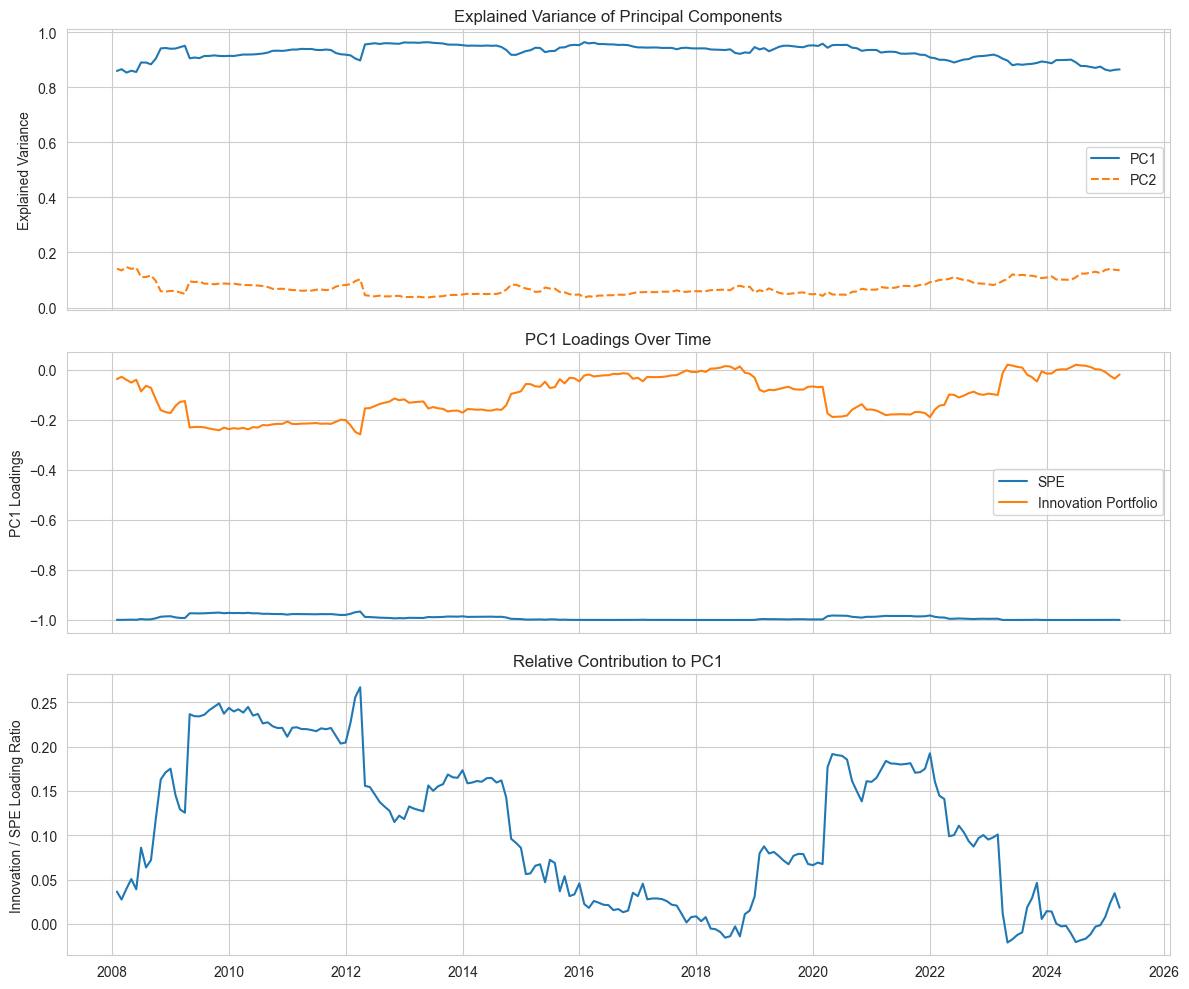

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Explained variance
axs[0].plot(rolling_pca_df.index, rolling_pca_df["PC1 Explained Var"], label="PC1")
axs[0].plot(rolling_pca_df.index, rolling_pca_df["PC2 Explained Var"], label="PC2", linestyle='--')
axs[0].set_ylabel("Explained Variance")
axs[0].set_title("Explained Variance of Principal Components")
axs[0].legend()

# PC1 loadings
axs[1].plot(rolling_pca_df.index, rolling_pca_df["PC1 SPE Loading"], label="SPE")
axs[1].plot(rolling_pca_df.index, rolling_pca_df["PC1 Innovation Loading"], label="Innovation Portfolio")
axs[1].set_ylabel("PC1 Loadings")
axs[1].set_title("PC1 Loadings Over Time")
axs[1].legend()

# Loading ratio
axs[2].plot(
    rolling_pca_df.index,
    rolling_pca_df["PC1 Innovation Loading"] / rolling_pca_df["PC1 SPE Loading"]
)
axs[2].set_ylabel("Innovation / SPE Loading Ratio")
axs[2].set_title("Relative Contribution to PC1")

plt.tight_layout()
plt.show()


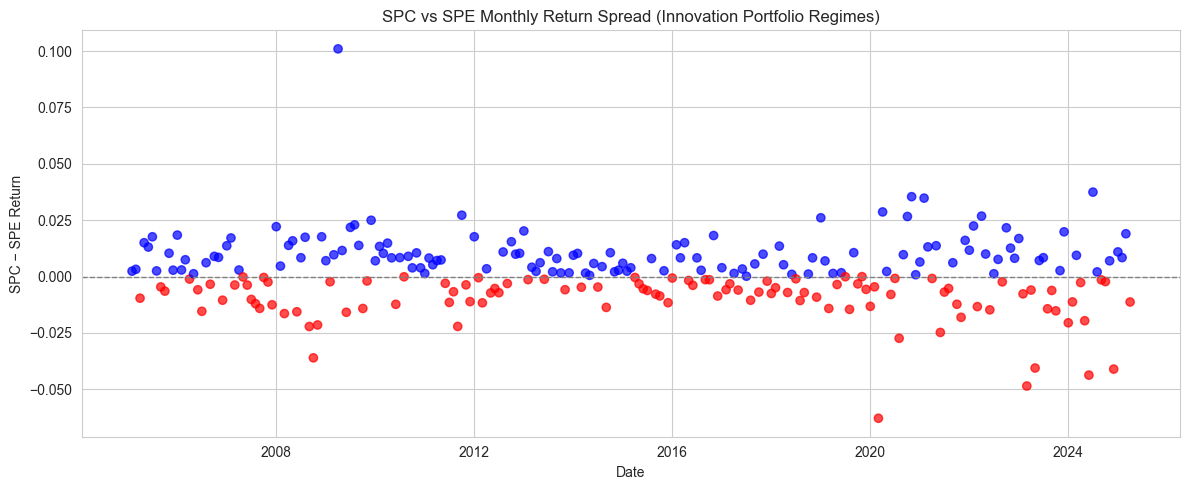

In [21]:
# Tag regimes: when SPC beats SPE (positive return) vs when SPE beats SPC (negative return)
returns_df["Regime"] = returns_df["Innovation Portfolio"].apply(lambda x: "SPC > SPE" if x > 0 else "SPE > SPC")

# Plot the regimes using color-coded scatter
plt.figure(figsize=(12, 5))
colors = returns_df["Innovation Portfolio"].apply(lambda x: 'blue' if x > 0 else 'red')

plt.scatter(returns_df.index, returns_df["Innovation Portfolio"], c=colors, label="SPC - SPE", alpha=0.7)
plt.axhline(0, linestyle='--', color='gray', linewidth=1)
plt.title("SPC vs SPE Monthly Return Spread (Innovation Portfolio Regimes)")
plt.xlabel("Date")
plt.ylabel("SPC − SPE Return")
plt.grid(True)
plt.tight_layout()
plt.show()
